In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data

import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Change to your working directory
os.chdir("/content/drive/MyDrive/Programming Assignment 2/")

# Load data from CSV
df_stock = pd.read_csv('Copy of NVDA_daily_data.csv')
df_news = pd.read_csv('nvda_news_headlines.csv')

print(df_stock.head())
print(df_news.head())

!ls


         Date     Open     High      Low    Close  Adj Close     Volume
0  2020-01-02  5.96875  5.99775  5.91800  5.99775   5.973122  237536000
1  2020-01-03  5.87750  5.94575  5.85250  5.90175   5.877516  205384000
2  2020-01-06  5.80800  5.93175  5.78175  5.92650   5.902164  262636000
3  2020-01-07  5.95500  6.04425  5.90975  5.99825   5.973620  314856000
4  2020-01-08  5.99400  6.05100  5.95375  6.00950   5.984823  277108000
                         Date                          Headline
0  2022-04-09 02:07:58.891882  guidance raised for next quarter
1  2022-04-10 02:07:58.891882        earnings beat expectations
2  2022-04-15 02:07:58.891882             trading volume spikes
3  2022-04-17 02:07:58.891882       up 15% after strong quarter
4  2022-04-18 02:07:58.891882        beats Wall Street estimate
'Copy of NVDA_daily_data.csv'   nvda_news_headlines.csv


In [ ]:
# Convert Date Columns to Datetime and Set as Index

df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)

df_news['Date'] = pd.to_datetime(df_news['Date'])
df_news.set_index('Date', inplace=True)


<ipython-input-39-f19be27494dc>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_stock['Volume'].resample('M').mean().to_frame(name='Avg_Monthly_Volume')


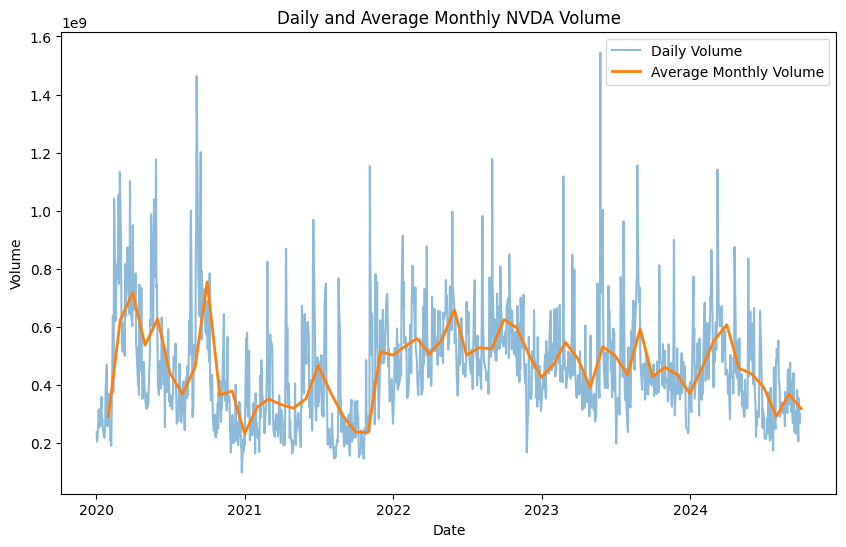

In [ ]:
# Downsample Daily Volume to Average Monthly Volume + Plot Chart

df_monthly = df_stock['Volume'].resample('M').mean().to_frame(name='Avg_Monthly_Volume')

plt.figure(figsize=(10,6))
plt.plot(df_stock.index, df_stock['Volume'], label='Daily Volume', alpha=0.5)
plt.plot(df_monthly.index, df_monthly['Avg_Monthly_Volume'], label='Average Monthly Volume', linewidth=2)
plt.title('Daily and Average Monthly NVDA Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


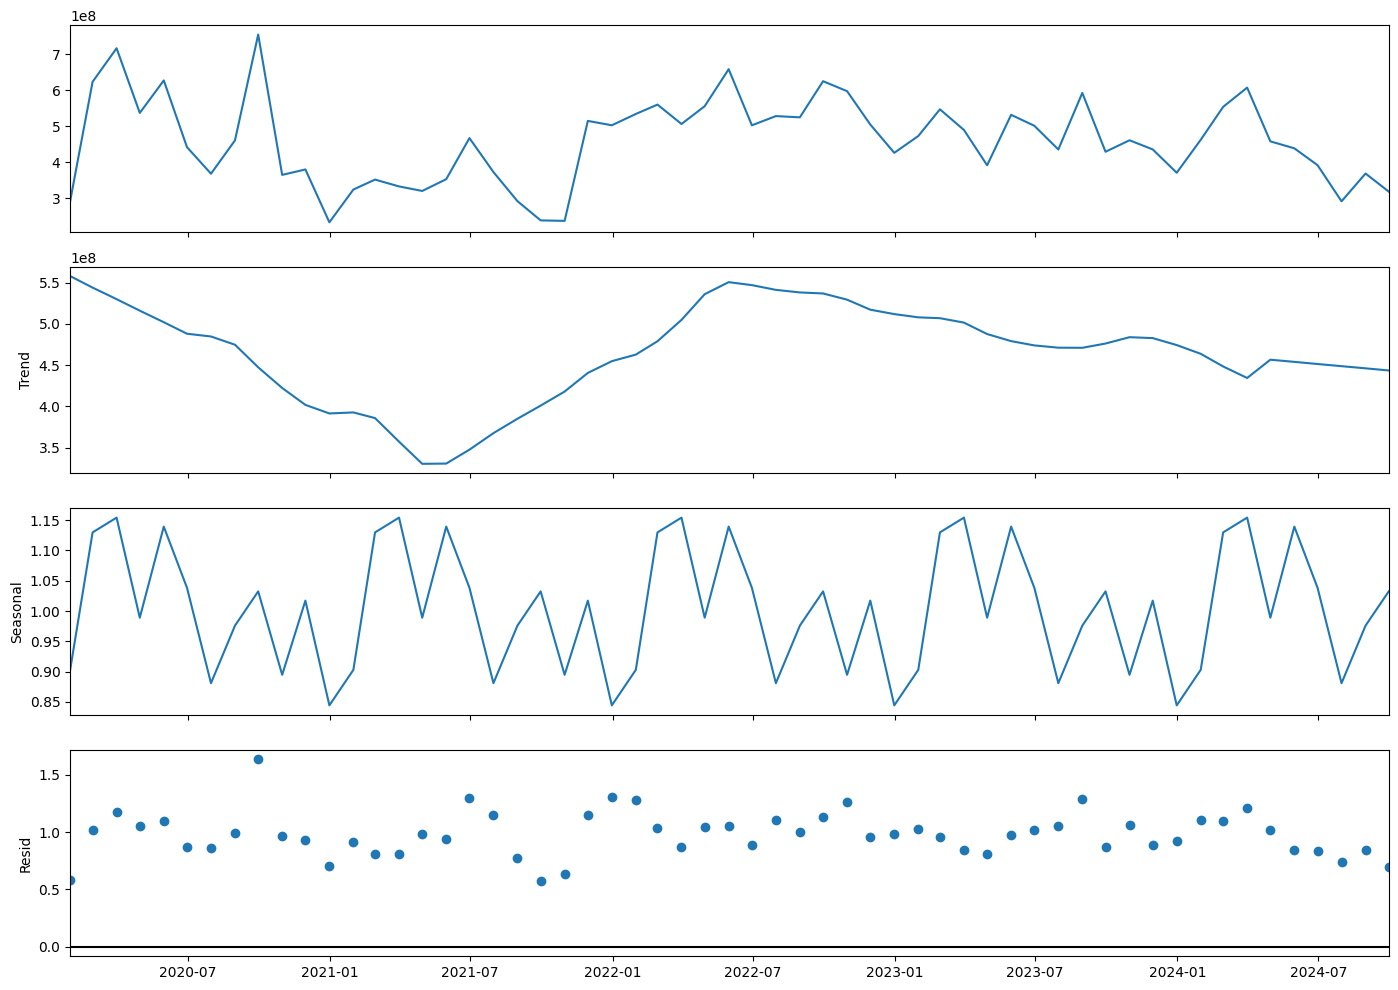

In [ ]:
# Time Series Decompoisition of Average Monthly Volume

decomposition = seasonal_decompose(df_monthly, model='multiplicative', period=12, extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()


In [ ]:
# Regex Based Feature Extraction on News Headlines

df_news['Contains_Earnings'] = df_news['Headline'].str.contains('earnings', case=False).map({True: 'Yes', False: 'No'})
df_news['Contains_Percent'] = df_news['Headline'].str.contains(r'\d+%', regex=True).map({True: 'Yes', False: 'No'})
df_news['Contains_Dollar'] = df_news['Headline'].str.contains(r'\$\d+(?:\.\d+)?', regex=True).map({True: 'Yes', False: 'No'})

print(df_news.head())


                                                    Headline  \
Date                                                           
2022-04-09 02:07:58.891882  guidance raised for next quarter   
2022-04-10 02:07:58.891882        earnings beat expectations   
2022-04-15 02:07:58.891882             trading volume spikes   
2022-04-17 02:07:58.891882       up 15% after strong quarter   
2022-04-18 02:07:58.891882        beats Wall Street estimate   

                           Contains_Earnings Contains_Percent Contains_Dollar  
Date                                                                           
2022-04-09 02:07:58.891882                No               No              No  
2022-04-10 02:07:58.891882               Yes               No              No  
2022-04-15 02:07:58.891882                No               No              No  
2022-04-17 02:07:58.891882                No              Yes              No  
2022-04-18 02:07:58.891882                No               No          

In [ ]:
# Normalize the datetime indices to remove the time component
df_stock.index = df_stock.index.normalize()
df_news.index = df_news.index.normalize()

# Optional: Inspect the date ranges in each DataFrame
print("Stock Data Date Range:")
print(df_stock.index.min(), "to", df_stock.index.max())

print("\nNews Data Date Range:")
print(df_news.index.min(), "to", df_news.index.max())

# Merge the DataFrames on the normalized Date index using an inner join
merged_df = df_stock.merge(df_news, left_index=True, right_index=True, how='inner')
print("\nMerged DataFrame Head:")
print(merged_df.head())


Stock Data Date Range:
2020-01-02 00:00:00 to 2024-09-27 00:00:00

News Data Date Range:
2022-04-09 00:00:00 to 2025-04-01 00:00:00

Merged DataFrame Head:
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2022-04-18  21.200001  22.087999  21.079000  21.783001  21.752037  525701000   
2022-05-02  18.541000  19.573999  18.391001  19.533001  19.505236  572049000   
2022-05-04  19.923000  20.400000  18.750999  20.334000  20.305096  648855000   
2022-05-11  17.347000  17.753000  16.568001  16.629999  16.606358  670167000   
2022-05-16  17.509001  17.788000  17.106001  17.264000  17.239460  521446000   

                                         Headline Contains_Earnings  \
Date                                                                  
2022-04-18             beats Wall Street estimate                No   
2022-05-02         NVIDIA announces $500M buyback                No   

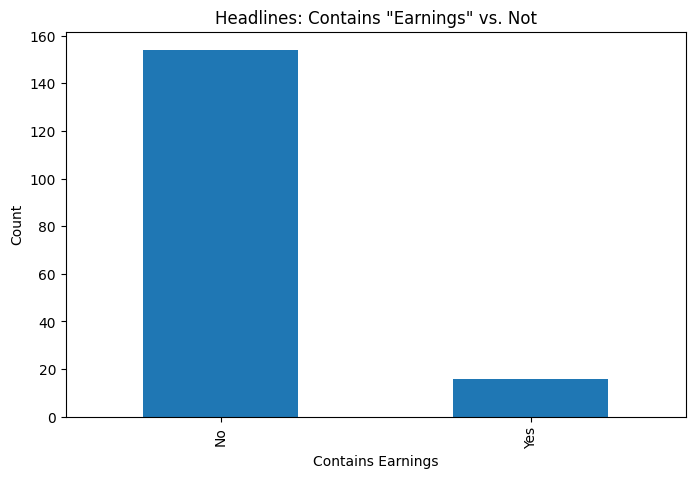

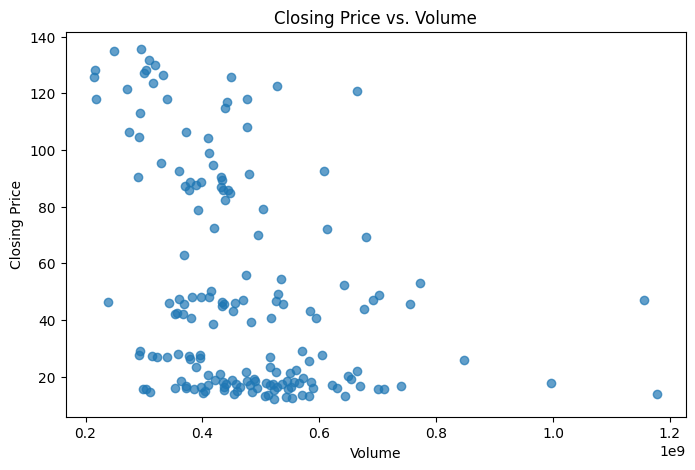

In [ ]:
# Bar Plot: Headlines Containing "Earnings"

# Generate counts from the merged dataset
earnings_counts = merged_df['Contains_Earnings'].value_counts()

# Check if earnings_counts is empty
if earnings_counts.empty:
    print("No data available in the merged dataframe for 'Contains_Earnings'. Please verify that the merge was successful and the date ranges overlap.")
else:
    plt.figure(figsize=(8,5))
    earnings_counts.plot(kind='bar')
    plt.title('Headlines: Contains "Earnings" vs. Not')
    plt.xlabel('Contains Earnings')
    plt.ylabel('Count')
    plt.show()

# Scatter Plot: Closing Price vs. Volume

if merged_df.empty:
    print("Merged dataframe is empty. Cannot plot Closing Price vs. Volume.")
else:
    plt.figure(figsize=(8,5))
    plt.scatter(merged_df['Volume'], merged_df['Close'], alpha=0.7)
    plt.title('Closing Price vs. Volume')
    plt.xlabel('Volume')
    plt.ylabel('Closing Price')
    plt.show()


# Analysis and Conclusions

1. **Benefit of Downsampling:**  
   Downsampling the daily data to monthly averages reduces the short term noise and volatility. This smoothingmethod makes it a lot easier to observe the underlying long term trends in NVDA’s trading volume without being distracted by daily fluctuations in the market.

2. **Observed Trend:**  
   The overall trend in the average monthly volume typically shows a gradual change over time (a steady increase or decrease). This trend reflects shifts in investor interest and market activity related to NVDA. Whether that be new innovations that NVDA releases that sparks more interest, or negative news relating to the company.

3. **Seasonal Component Pattern:**  
   The seasonal component tends to express a consistent repeating pattern each year. The pattern is moderately strong, indicating that certain periods (such as earnings seasons or end of year cycles) consistently experience higher or lower trading volumes.

4. **Residual Component Insight:**  
   The residual component captures the random, irregular fluctuations that are not explained by the trend or seasonal effects. Large residuals may highlight anomalies or one off events, while smaller residuals suggest that the model (trend seasonality) accounts well for the variation in the data.

5. **Regex for Percentages in Headlines:**  
   Most headlines flagged with percentages do tend to describe NVDA stock movements such as increases or decreases in stock price. However, the regex may occasionally capture percentages that reference other unrelated figures (general statistics), so some manual review might be required to confirm context.

6. **Relationship Between Trading Volume and Closing Price:**  
   The scatter plot shows that higher trading volumes may be associated with more pronounced changes in the closing price. However, the relationship is not strictly linear, suggesting that other factors might also be influencing price movements that we may not know about.

7. **Clusters in Scatter Plot:**  
   There appear to be clusters of points at specific volume or price levels. These clusters might indicate common trading ranges or key levels (such as support and resistance) where trading activity tends to concentrate.

8. **Overall Summary:**  
   By downsampling, decomposing, and visualizing the data, we gain a clearer understanding of the underlying trends, seasonal behaviors, and irregular events impacting NVDA’s trading activity. This approach enables better interpretation of how market movements and news events correlate over time.


In [ ]:
from google.colab import files
!jupyter nbconvert --to html "Assignment2"

!ls

[NbConvertApp] WARNING | pattern 'Assignment2' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execu